<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Deep%20Learning%20with%20Keras%20and%20Tensorflow/Final%20Projects/Fruit_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import zipfile

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

response = requests.get(url, stream=True)
with open(local_zip, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Dataset extracted to '{extract_dir}'")

os.remove(local_zip)
print(f"Cleaned up zip file: {local_zip}")

Dataset extracted to 'fruits-360-original-size'
Cleaned up zip file: fruits-360-original-size.zip


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Loading images and applying data augmentation
from tensorflow.keras.applications import VGG16 # Pre-trained model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, # Normalize pixel values to be between 0 and 1
    rotation_range=40, # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2, # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2, # Apply random shear transformations
    zoom_range=0.2, # Randomly zoom images by up to 20%
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest' # Fill in newly created pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [ ]:
# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model on the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6) # Learning rate scsheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early Stopping

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 79s 177ms/step - accuracy: 0.2380 - loss: 2.8549 - val_accuracy: 0.7103 - val_loss: 0.8267 - learning_rate: 0.0010
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 59s 149ms/step - accuracy: 0.5718 - loss: 1.2797 - val_accuracy: 0.8834 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 59s 149ms/step - accuracy: 0.6752 - loss: 0.9682 - val_accuracy: 0.9348 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - accuracy: 0.7255 - loss: 0.7998 - val_accuracy: 0.8744 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.7500 - loss: 0.7082 - val_accuracy: 0.8982 - val_loss: 0.2519 - learning_rate: 0.0010


In [ ]:
# Unfreeze the last 4 layers in the base model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Re-compile the model with a smaller learning rate
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/2
390/390 ━━━━━━━━━━━━━━━━━━━━ 69s 163ms/step - accuracy: 0.7495 - loss: 0.7418 - val_accuracy: 0.9297 - val_loss: 0.2116 - learning_rate: 1.0000e-05
Epoch 2/2
390/390 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.7584 - loss: 0.6931 - val_accuracy: 0.9387 - val_loss: 0.1873 - learning_rate: 1.0000e-05


In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9405 - loss: 0.1857
Test Accuracy: 0.94


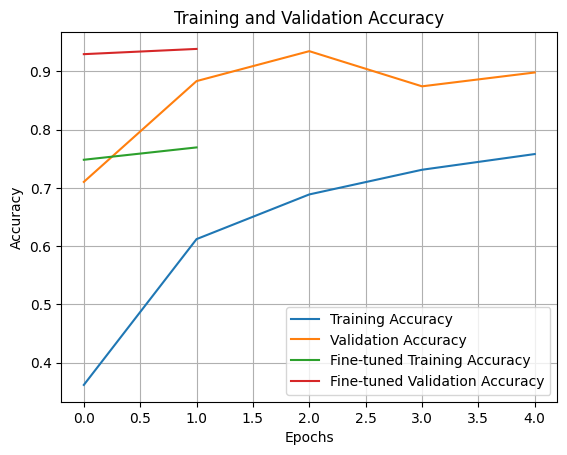

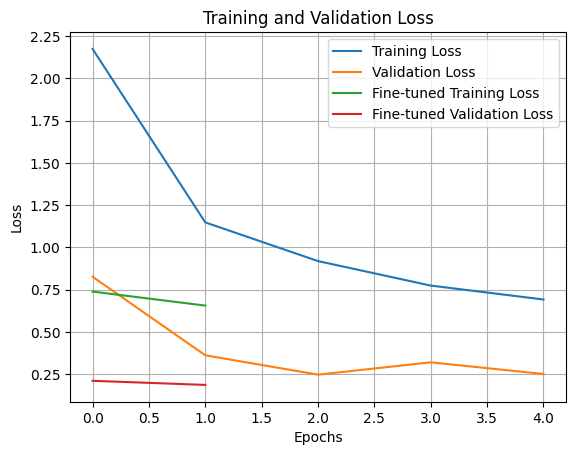

In [ ]:
# Plotting
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
img_path

'/path/to/test_image1.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


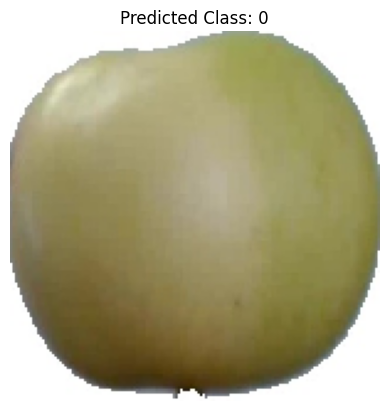

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


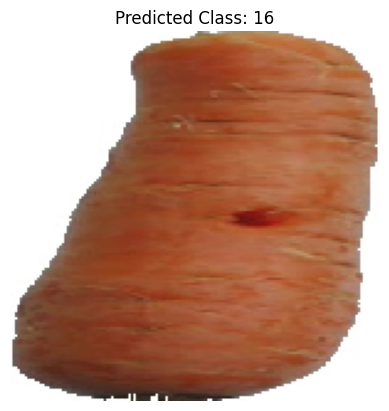

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


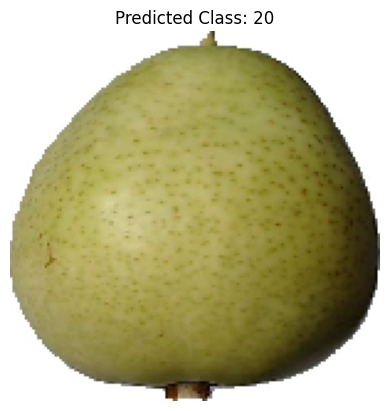

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to visualize a test image with prediction
def visualize_prediction(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)

    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class[0]}")
    plt.axis('off')
    plt.show()

# Test on a few images
sample_images = [
    '/content/fruits-360-original-size/fruits-360-original-size/Validation/apple_6/r0_1.jpg',
    '/content/fruits-360-original-size/fruits-360-original-size/Validation/carrot_1/r0_1.jpg',
    '/content/fruits-360-original-size/fruits-360-original-size/Validation/pear_1/r0_121.jpg'
]

for img_path in sample_images:
    visualize_prediction(img_path)